This notebook uses auto-regression techniques to study the behavior in the calibration value.

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now lets try some autoregression
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import MinMaxScaler

In [2]:
xtal_list = [54000,54001,54002,54003,54004,54005,54006,54007,54008,54009]
#preload test data
test_xtals = {}
results = {}
xtals_df = pd.DataFrame(columns=xtal_list)
for xtal in xtal_list:
    print('Loading xtal: {}'.format(xtal))
    suffix = '_{}.csv'.format(xtal)
    test = pd.read_csv('../data/test_diff'+suffix, index_col=0)
    
    test.index = pd.to_datetime(test.index)
    test = test[['p2']]
 #   print(test.head())
    
    test_xtals[xtal] = test
    xtals_df[xtal] = test.p2
    

Loading xtal: 54000
Loading xtal: 54001
Loading xtal: 54002
Loading xtal: 54003
Loading xtal: 54004
Loading xtal: 54005
Loading xtal: 54006
Loading xtal: 54007
Loading xtal: 54008
Loading xtal: 54009


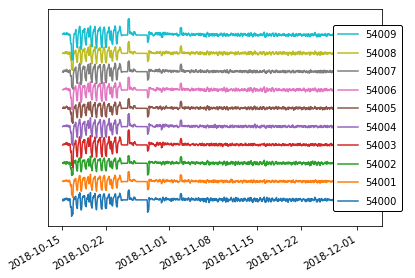

In [3]:
xtals_df_shft = xtals_df.copy()

for i,xtal in enumerate(xtal_list):
    xtals_df_shft[xtal] = xtals_df[xtal]+i*.002
#plot = xtals_df_shft.plot(legend=False)
fig, ax = plt.subplots()
ax.set_ylabel('Calibration values')
for xtal in xtal_list:
    ax.plot(xtals_df_shft[xtal],label=str(xtal))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
handles, labels = ax.get_legend_handles_labels()
ax.get_yaxis().set_visible(False)

fig.legend(handles[::-1], labels[::-1],ncol=1,labelspacing=0.85,loc=(0.8,0.24),edgecolor='black',facecolor='white',framealpha=1,borderpad=0.5)

fig.show()

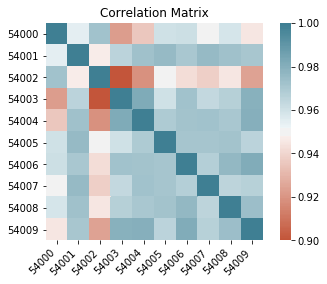

In [4]:
fig, ax = plt.subplots()

ax.set_title('Correlation Matrix')
corr = xtals_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=0.9, vmax=1, center=0.95,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

Loading xtal: 54000
                           p2
2018-05-12 09:01:31  0.000313
2018-05-12 10:01:31  0.000278
2018-05-12 11:01:31  0.000343
2018-05-12 12:01:31  0.000585
2018-05-12 13:01:31  0.000699
                           p2
2018-05-12 09:01:31  0.606049
2018-05-12 10:01:31  0.599961
2018-05-12 11:01:31  0.611185
2018-05-12 12:01:31  0.652975
2018-05-12 13:01:31  0.672792
                           p2
2018-10-15 01:36:23 -0.000080
2018-10-15 02:36:23  0.000068
2018-10-15 03:36:23  0.000013
2018-10-15 04:36:23 -0.000079
2018-10-15 05:36:23  0.000072
                           p2
2018-10-15 01:36:23  0.538027
2018-10-15 02:36:23  0.563726
2018-10-15 03:36:23  0.554162
2018-10-15 04:36:23  0.538222
2018-10-15 05:36:23  0.564354
                           p2      p2+1      p2+2
2018-10-15 01:36:23  0.538027  0.563726  0.554162
2018-10-15 02:36:23  0.563726  0.554162  0.538222
2018-10-15 03:36:23  0.554162  0.538222  0.564354
2018-10-15 04:36:23  0.538222  0.564354  0.559399
2018-10-15

/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/rusack/evans908/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dime

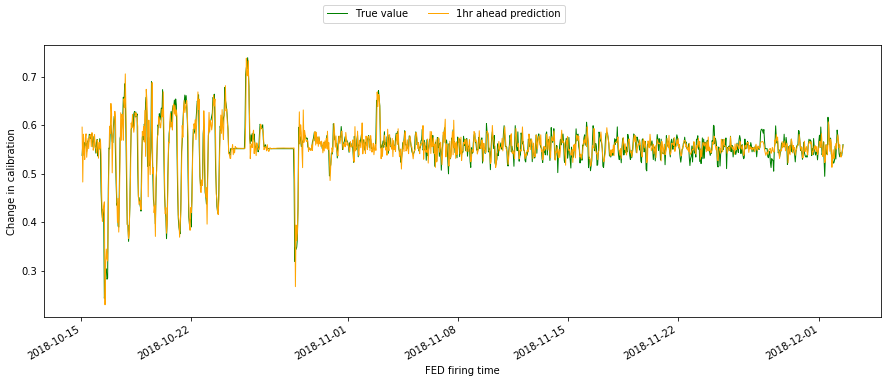

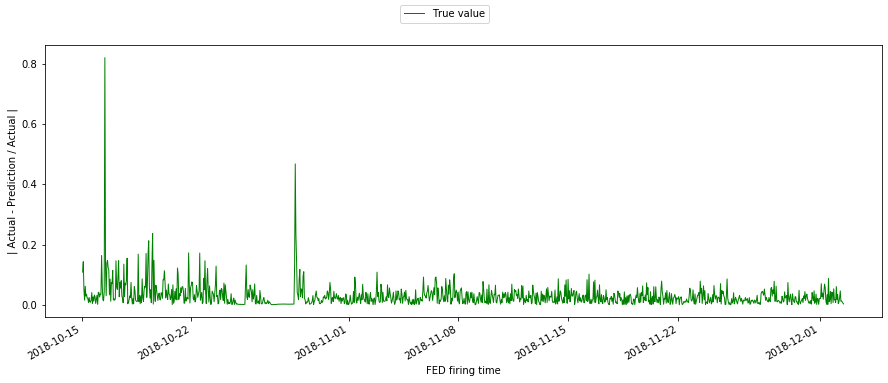

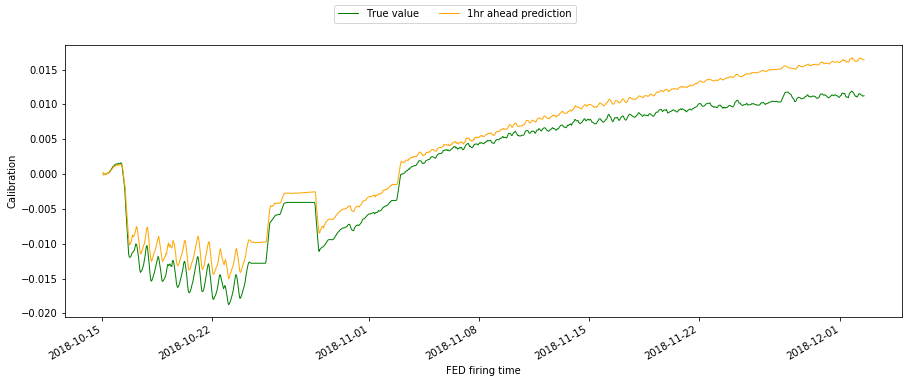

In [8]:
figs = []
xtal_list =[54000]
for xtal in xtal_list:
    #load the data###################################
    #the other xtals
    sub_list = xtal_list.copy()
    sub_list.remove(xtal)
    #
    print('Loading xtal: {}'.format(xtal))
    valid = pd.read_csv('../data/valid_diff'+suffix, index_col=0)
    train = pd.read_csv('../data/train_diff'+suffix, index_col=0)
    #set index to datetime
    
    valid.index = pd.to_datetime(valid.index)
    train.index = pd.to_datetime(train.index)
    #only take calibration values
    
    valid = valid[['p2']]
    train = train[['p2']]
    
    #lets pool the valid and train data together
    train = train.append(valid)

    #shape input data#################################
    
    scaler = MinMaxScaler()
    print(train.head())
    train['p2'] = scaler.fit_transform(train)[:,0]
    print(train.head())

    test = test_xtals[xtal].copy()
    print(test.head())
    test['p2'] = scaler.transform(test)[:,0]
    print(test.head())
    #Number of steps to forecast ahead
    test_shifted = test.copy()
    HORIZON = 3
    #create test data points for each horizon
    for t in range(1, HORIZON):
        test_shifted['p2+'+str(t)] = test_shifted['p2'].shift(-t, freq='H')

    test_shifted = test_shifted.dropna(how='any')
    print(test_shifted.head(5))

    #make predictions on the test data#################
    training_window = 500
    train_series = train['p2']
    test_series = test_shifted
    lag = 10

    history = [x for x in train_series]
    history = history[(-training_window):]
    predictions = list()
    for t in range(test_series.shape[0]):
        model = AutoReg(history, lag, old_names=False)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=HORIZON)
        predictions.append(yhat)
        obs = list(test_series.iloc[t])

        # move the training window
        history.append(obs[0])
        history.pop(0)
        #print(test_series.index[t])
        #print(t+1, ': predicted =', yhat, 'expected =', obs)
    pred_np = np.array(predictions)
    #calculate MAPE
    mape1 = mape(pred_np[:,0], test_series['p2'])
    mape2 = mape(pred_np[:,1], test_series['p2+1'])
    mape3 = mape(pred_np[:,2], test_series['p2+2'])
    print('Evaluating AR({}) on same xtal:'.format(lag))
    print("\tMAPE prediction 1 hour  ahead: {:.1%}".format(mape1),
              "\n\tMAPE prediction 2 hours ahead: {:.1%}".format(mape2),
              "\n\tMAPE prediction 3 hours ahead: {:.1%}".format(mape3))
    my_mapes = [mape1, mape2, mape3]
    #make a pretty picture
    #lets make some plots##############################################
    fig1, ax1 = plt.subplots(figsize=(15,5))

    ax1.set_ylabel('Change in calibration')
    ax1.set_xlabel('FED firing time')
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')

    #actual data
    ax1.plot(test_series.index, test_series.p2, 
         label='True value', color='green', linewidth=1, linestyle='solid')
    ax1.plot(test_series.index, pred_np[:,0], 
         label='1hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
    #legend
    fig1.legend(ncol=3, loc = 'upper center')
    

    ####MAKE DIFF PLOT########
    apdiff_series = ((test_series.p2 - pred_np[:,0]) / test_series.p2).abs()
    fig3, ax3 = plt.subplots(figsize=(15,5))

    ax3.set_ylabel('| Actual - Prediction / Actual |')
    ax3.set_xlabel('FED firing time')
    plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

    #actual data
    ax3.plot(test_series.index, apdiff_series, 
         label='True value', color='green', linewidth=1, linestyle='solid')
    #legend
    fig3.legend(ncol=3, loc = 'upper center')
    
    
    #######CUMSUM PLOT###############
    fig2, ax2 = plt.subplots(figsize=(15,5))

    ax2.set_ylabel('Calibration')
    ax2.set_xlabel('FED firing time')
    plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
    #make cumulative data
    cs_ts = np.cumsum(scaler.inverse_transform(test_series[['p2']]))
    pred_df = test_series[['p2']].copy()
    pred_df['p2'] = pred_np[:,0]
    cs_ps = np.cumsum(scaler.inverse_transform(pred_df[['p2']]))
    #actual data
    ax2.plot(test_series.index, cs_ts, 
         label='True value', color='green', linewidth=1, linestyle='solid')
    ax2.plot(test_series.index, cs_ps, 
         label='1hr ahead prediction', color='orange', linewidth=1, linestyle='solid')
    #legend
    fig2.legend(ncol=3, loc = 'upper center')
    
    figs.append((fig1, fig2))
    results[xtal] = tuple(my_mapes)
    
    #PERSISTANCE MODEL
    fig4, ax4 = plt.subplots()
    
    


In [6]:
#now let's summarize everything

results_df = pd.DataFrame.from_dict(results, orient='index',columns=['MAPE1', 'MAPE2', 'MAPE3'])
results_df.head(10)

,MAPE1,MAPE2,MAPE3
54000,0.0292,0.039177,0.044977


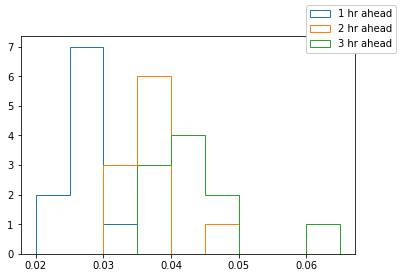

In [7]:
fig, ax = plt.subplots()
ax.hist(results_df.MAPE1,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='1 hr ahead')
ax.hist(results_df.MAPE2,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='2 hr ahead')
ax.hist(results_df.MAPE3,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='3 hr ahead')
fig.legend(loc='upper right',facecolor='white',framealpha=1)

/panfs/roc/msisoft/anaconda/anaconda3-2018.12/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


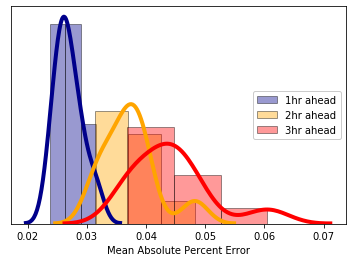

In [8]:
# Density Plot
sns.distplot(results_df.MAPE1, hist=True, kde=True, 
             bins=3, color = 'darkblue', label = '1hr ahead',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
sns.distplot(results_df.MAPE2, hist=True, kde=True, 
             bins=3, color = 'orange', label = '2hr ahead',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax = sns.distplot(results_df.MAPE3, hist=True, kde=True, 
             bins=3, color = 'red', label = '3hr ahead',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
#ax.hist(results_df.MAPE1,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='1 hr ahead')
#ax.hist(results_df.MAPE2,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='2 hr ahead')
#ax.hist(results_df.MAPE3,bins=[0.02,0.025,0.03,0.035,.04,.045,.05,.055,.06,.065],histtype='step',label='3 hr ahead')
ax.legend(loc='right',facecolor='white',framealpha=1)
ax.set_xlabel('Mean Absolute Percent Error')
ax.get_yaxis().set_visible(False)